In [105]:
#Load some modules etc
%matplotlib inline
import matplotlib.pyplot as plt
from cycler import cycler

from sympy import *
import scipy as sc
import numpy as np
init_printing()

# Introduction

In this notebook I run thorugh the theory asociated with the microbial competition experiments. The basic idea is to develop a model which describes the temperature dependence of respiratory flux in communities with interacting species. This requires the model to not only describe the temperature dependence of metabolism itself (as classic MTE does) but also the change in flux that occurs due to the temperature dependence of species interactions. 

First I show how the temperature dependence of total respiratory flux of a population can be approximated assuming a temperature dependence of growth rate. I then describe growth in communities in multiple non-interacting species before moving to communities with species interactions. For now all of these models describe communities in the exponential growth phase where I assume that resources are non-limited (as is the case in the experiments). 

# Single Species model

The total respiratory flux of a single species, $R_s$, can be obtained by multiplying it's carbon biomass $C_s$ with it's mass-specific flux, $\tilde{R}_s$.

\begin{align}
    R_s = C_s \tilde{R}_s
\end{align}

We rewrite the mass-specific respiration portion of this equation using a modified form of the Arrhenius equation:

\begin{align}
    \tilde{R}_s = \tilde{R}_0 e^{-E_R (T_r - T_{ra})}
\end{align}

and assuming the population is in the exponential growth phase, we can also write the biomass using the expontial growth formula:

\begin{align}
    C_s = C_0 e^{rt}
\end{align}

which when combined gives:

\begin{align}
    R_s = C_0 e^{rt} \tilde{R}_0 e^{-E_R (T_r - T_{ra})}
\end{align}

looking at the model above we can see that in the case where growth,$r$, does not depend on temp the temperature dependence will be equal to the dependence of $\tilde{R}_s$ ($E_R$).

## Temperature dependent growth

More realistic is the case where growth rate depends on temperature in addition to respiration. Though this may take several forms here I assume that it can be described using the Arrhenius equation:

\begin{align}
 r = r_0 e^{-E_r (T_r - T_{ra})}
\end{align}

thus the total equation becomes: 

\begin{align}
    R_s = C_0 e^{t r_0 e^{-E_r (T_r - T_{ra})}} \tilde{R}_0 e^{-E_R (T_r - T_{ra})}
\end{align}

This means that the temperature dependence can no longer be described simply by the dependence of respiration. The double exponential form of the growth component prevents us from combining the two temperature terms straight away. To get arround this we can approximate the temperature dependence of the carbon biomass growth term ($C_s = C_0 e^{rt}$) by preforming a taylor series expansion around $T_r = T_{ra}$:

In [353]:
C_0,t,T_r,T_ra,E_r,r_0 = var("C_0,t,T_r,T_ra,E_r,r_0")

r = r_0 * exp(-E_r * (T_r - T_ra))
grow = C_0 * exp(t*r)

grow

In [354]:
grow_log = log(grow)
approx_grow = exp(grow_log.series(T_r,T_ra,2).removeO())
approx_grow

So the temperature dependence of biomass at time $t$ can be approximated as $-E_r r_0 t$. We can look at the quality of this apporoximation by looking at the next term of the taylor series which if the approxmiation is good, should be much smaller.

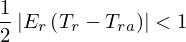

In [355]:
def taylor(n,x,a,f):
    if(n == 0):
        return(f.subs({x:a}))
    else:
        return((diff(f,x,n).subs({x:a}) / factorial(n)) * ((x-a) ** n))
    
approx = abs(taylor(2,T_r,T_ra,grow_log)/taylor(1,T_r,T_ra,grow_log)) < 1
approx

The value of the temperature term in this expression will range from 2.86 (at 275K) to -2.86 (at 315K). We substitute the maximum value of this into the inequality to get:

In [356]:
k = 8.617e-5
approx_T = approx.subs({T_r-T_ra:((1/(k*275)) - (1/(k*295)) )})
approx_T

In [357]:
-2 / ((1/(k*275)) - (1/(k*295)))

which when we solve for $E_r$ gives:

In [358]:
solve(approx_T)

So for the approximation to be good the temperature sensivity of growth must be smaller than $0.69$. We can test this graphically by plotting the temperature dependence of growth:

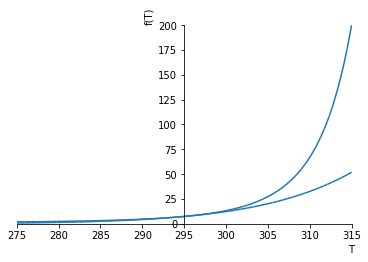

In [376]:
T = var("T")

real_growth =        grow.subs({C_0:1,r_0:1,t:2,T_r:1/(k*T),T_ra:1/(k*295),E_r:0.39})
appr_growth = approx_grow.subs({C_0:1,r_0:1,t:2,T_r:1/(k*T),T_ra:1/(k*295),E_r:0.39})

plot(real_growth,appr_growth,(T,275,315))

Needs work, i dont think the inequality is correct...

### Total respiration

using this approximation of growth we can get the temperature dependence of total respiration by substituting in the new growth term. This means we go from:

\begin{align}
    R_s = C_0 e^{t r_0 e^{-E_r (T_r - T_{ra})}} \tilde{R}_0 e^{-E_R (T_r - T_{ra})}
\end{align} 

to:

\begin{align}
    R_s &= C_{0} e^{r_{0} t} e^{- E_{r} r_{0} t (T_{r} - T_{ra})} \tilde{R}_0 e^{-E_R (T_r - T_{ra})} \\
    &= C_{0} \tilde{R}_0 e^{r_{0} t}  e^{(-E_R - E_{r} r_{0} t) (T_r - T_{ra})}
\end{align}

So the temperature dependence of total respiration can be expressed as $-E_R - E_{r} r_{0} t$ 

# Two species model

We can extend this model of total respiration to a two species system. In the simplest case with no interactions (i.e. the growth rates of both species are independent) we can write the respiration in the system as:

\begin{align}
    R_{tot} &= R_1 + R_2 \\
            &= C_1 \tilde{R}_1 + C_2 \tilde{R}_2 \\
            &= C_{0_1} \tilde{R}_{0_1} e^{r_{0_1} t}  e^{(-E_{R_1} - E_{r_1} r_{0_1} t) (T_r - T_{ra})} + 
               C_{0_2} \tilde{R}_{0_2} e^{r_{0_2} t}  e^{(-E_{R_2} - E_{r_2} r_{0_2} t) (T_r - T_{ra})}
\end{align}

we can simplify this somewhat by assuing that the starting biomass for each species is equal (i.e. $C_{0_1} = C_{0_2}$). As with the classic static model we can approximate this sum of boltzman-type equations by taking the log and using a taylor series expansion around the point $T_r = T_{ra}$: 

In [207]:
R1,R2,ER1,ER2 = var("R_{0_1},R_{0_2},E_{R_1},E_{R_2}")
r1,r2,Er1,Er2 = var("r_{0_1},r_{0_2},E_{r_1},E_{r_2}")
t,T_r,T_ra,C_0 = var("t,T_r,T_ra,C_0")


one = C_0 * R1 * exp(r1*t) * exp((-ER1 - (Er1*r1*t))*(T_r-T_ra))
two = C_0 * R2 * exp(r2*t) * exp((-ER2 - (Er2*r2*t))*(T_r-T_ra))

one + two

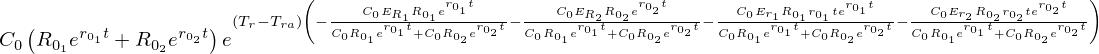

In [209]:
exp(log(one+two).series(T_r,T_ra,2).removeO())

this result can be simplified and generalised to the n-species case where:

\begin{align}
    R_{tot} = C_0 \sum_{s = 0}^{n} R_{0_s} e^{r_{0_s} t} e^{(T_r - T_{ra}) 
    \frac{C_0 \sum_{s = 0}^{n} R_{0_s} e^{r_{0_s} t} (-E_{R_s} - E_{r_s} r_{0_s} t)}
         {C_0 \sum_{s = 0}^{n} R_{0_s} e^{r_{0_s} t}} }
\end{align}

so the temperature sensitivity is the weighted average of the sensitivites of each component. 

## Species interactions

The model above does not include species interactions. We can include these interactions as changes in growth rate which can simply be included as adative effects in the growth model

\begin{align}
    \frac{dC_1}{dt} = C_1 (r_1 + \alpha_1 C_2)
    \\
    \\
    \frac{dC_2}{dt} = C_2 (r_2 + \alpha_2 C_1)
\end{align}

where $r_s$ is the mass-specific growth rate and $\alpha_s$ is the mass-specific effect on the growth of species $s$   As with the classic exponential growth model we can solve this equation to get the biomass at time $t$, $C_s(t)$ which gives:

\begin{align}
    C_1(t) &= C_0 e^{t(r_1 + \alpha_1 C_2)} \\
           &= C_0 e^{t(r_1 + \alpha_1 C_0 e^{t(r_2 + \alpha_2 C_1)})}
\end{align}

In [352]:
C_1,C_2,r_1,r_2,t,a_1,a_2,C_0 = var("C_1,C_2,r_1,r_2,t,a_1,a_2,C_0")

dC_1 = C_1 * (r_1 + a_1*C_2)
dC_2 = C_2 * (r_2 + a_2*C_1)



C_1_sol = exp(integrate(r_1+a_1*C_2,t) + log(C_0))
C_2_sol = exp(integrate(r_2+a_2*C_1,t) + log(C_0))

C_1_full = C_1_sol.subs({C_2:C_2_sol})

# p1 = log(C_1_sol.subs({C_2:C_2_sol})).series(t,0,2).removeO()


# expand_log(p1,force=true)
C_1_sol